### Interpretability of Attention-based MIL

In this session, we will explore two post-hoc interpretability methods for understanding the behaviour of an Attention-based MIL model trained to subtype lung cancer into LUAD and LUSC, the two most common lung cancer subtypes.


#### On the importance of interpretability in medical AI applications

- **Trust & control**: Medical AI systems are often used in critical decision-making processes that directly impact patients' health and lives. Interpretability aims to provide the right level of insights and control over the system such that trust and confidence can be established between users and the system.


- **Insights and Understanding**: Interpretable models are also valuable to provide insights into the underlying factors or features that contribute to a prediction. In medical AI, this understanding can be critical for healthcare professionals to gain insights into disease mechanisms, identify risk factors, or discover novel biomarkers. This aspect goes in the direction of biomarker discovery, where we assume that the AI system might use different features than what form the current standard (e.g., the current grading criteria in cancer).


- **Error Analysis and Diagnosis**: Interpretability helps in error analysis, allowing the identification and understanding of the model's mistakes or mispredictions. In medical AI, where misdiagnoses can have severe consequences, interpretability enables clinicians to evaluate cases where the model failed and diagnose potential pitfalls or limitations. This feedback loop can guide improvements in the model, dataset, or feature engineering, leading to better performance and more reliable predictions.


And the wishful thinking considerations...


- **Legal and Ethical Considerations**: The interpretability of AI models could be used for addressing legal and ethical concerns. In healthcare, decisions made by AI systems need to be explainable to patients, healthcare professionals, regulatory bodies, and other stakeholders. By providing interpretability, AI systems can adhere to legal requirements, such as the General Data Protection Regulation (GDPR), which grants individuals the right to an explanation for automated decisions that significantly impact them.


- **Safety and Robustness**: Deep learning models are susceptible to biases, adversarial attacks, or data distribution shifts that can lead to incorrect or unreliable predictions. Interpretability helps in detecting these issues and assessing the model's safety and robustness. By understanding the model's internal workings, it becomes possible to identify potential biases, investigate cases where the model may be overconfident or underperform, and design safeguards to mitigate risks.


- **Regulatory Compliance**: Interpretability is increasingly becoming a regulatory requirement in various domains, including healthcare. Regulatory bodies, such as the U.S. Food and Drug Administration (FDA), often demand explanations and justifications for the decisions made by AI systems before approving their deployment. Interpretability allows the model's behavior to be audited, validated, and aligned with regulatory standards, ensuring compliance and patient safety.


In [1]:
# All data can be downloaded here: https://drive.google.com/drive/folders/1TmAfG7EWC1hjD7cHFGiJzUx2y3jLXdcP?usp=sharing
# Once downloaded, transfer the data into your local cloned repo 

use_drive = False
if use_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir -p "/content/drive/My Drive/ai4healthsummerschool/"

In [2]:
# Load and print ABMIL model previously trained
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

class AttentionTanhSigmoidGating(nn.Module):
    def __init__(self, D=64, L=64, dropout=0.25):
        r"""
        Global attention pooling layer with tanh non-linearity and sigmoid gating (Ilse et al. 2018).

        Args:
            D (int): input feature dimension.
            L (int): hidden layer dimension. Notation changed from M from Ilse et al 2018, as M is overloaded to also describe # of patch embeddings in a WSI.
            dropout (float): Dropout probability.

        Returns:
            A_norm (torch.Tensor): [M x 1]-dim tensor of normalized attention scores (sum to 1)
        """
        super(AttentionTanhSigmoidGating, self).__init__()
        self.tanhV = nn.Sequential(*[nn.Linear(D, L), nn.Tanh(), nn.Dropout(dropout)])
        self.sigmU = nn.Sequential(*[nn.Linear(D, L), nn.Sigmoid(), nn.Dropout(dropout)])
        self.w = nn.Linear(L, 1)

    def forward(self, H, return_raw_attention=False):
        A_raw = self.w(self.tanhV(H).mul(self.sigmU(H))) # exponent term
        A_norm = F.softmax(A_raw, dim=0)                 # apply softmax to normalize weights to 1
        assert abs(A_norm.sum() - 1) < 1e-3              # Assert statement to check sum(A) ~= 1
        if return_raw_attention:
            return A_norm, A_raw
        return A_norm


class ABMIL(nn.Module):
    def __init__(self, input_dim=320, hidden_dim=64, dropout=0.25, n_classes=2):
        r"""
        Attention-Based Multiple Instance Learning (Ilse et al. 2018).

        Args:
            input_dim (int): input feature dimension.
            hidden_dim (int): hidden layer dimension.
            dropout (float): Dropout probability.
            n_classes (int): Number of classes.
        """
        super(ABMIL, self).__init__()
        self.inst_level_fc = nn.Sequential(*[nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout)]) # Fully-Connected Layer, applied "instance-wise" to each embedding
        self.global_attn = AttentionTanhSigmoidGating(L=hidden_dim, D=hidden_dim)                              # Attention Function
        self.bag_level_classifier = nn.Linear(hidden_dim, n_classes)                                            # Bag-Level Classifier

    def forward(self, X: torch.randn(100, 320), return_raw_attention=False):
        r"""
        Takes as input a [M x D]-dim bag of patch features (representing a WSI), and outputs: 1) logits for classification, 2) un-normalized attention scores.

        Args:
            X (torch.Tensor): [M x D]-dim bag of patch features (representing a WSI)

        Returns:
            logits (torch.Tensor): [1 x n_classes]-dim tensor of un-normalized logits for classification task.
            A_norm (torch.Tensor): [M,]- or [M x 1]-dim tensor of attention scores.
        """
        H_inst = self.inst_level_fc(X)         # 1. Process each feature embedding to be of size "hidden-dim"
        if return_raw_attention:
            A_norm, A_raw = self.global_attn(H_inst, return_raw_attention=True)
        else:
            A_norm = self.global_attn(H_inst)      # 2. Get normalized attention scores for each embedding (s.t. sum(A_norm) ~= 1)
        z = torch.sum(A_norm * H_inst, dim=0)  # 3. Output of global attention pooling over the bag
        logits = self.bag_level_classifier(z).unsqueeze(dim=0)   # 4. Get un-normalized logits for classification task
        try:
            assert logits.shape == (1,2)
        except:
            print(f"Logit tensor shape is not formatted correctly. Should output [1 x 2] shape, but got {logits.shape} shape")
        
        if return_raw_attention:
            return logits, A_raw
        return logits, A_norm

    def captum(self, X: torch.randn(100, 320)):
        r"""
        Takes as input a [M x D]-dim bag of patch features (representing a WSI), and outputs: 1) logits for classification, 2) un-normalized attention scores.

        Args:
            X (torch.Tensor): [M x D]-dim bag of patch features (representing a WSI)

        Returns:
            logits (torch.Tensor): [1 x n_classes]-dim tensor of un-normalized logits for classification task.
            A_norm (torch.Tensor): [M,]- or [M x 1]-dim tensor of attention scores.
        """
        H_inst = self.inst_level_fc(X)         # 1. Process each feature embedding to be of size "hidden-dim"
        A_norm = self.global_attn(H_inst)      # 2. Get normalized attention scores for each embedding (s.t. sum(A_norm) ~= 1)
        z = torch.sum(A_norm * H_inst, dim=0)  # 3. Output of global attention pooling over the bag
        logits = self.bag_level_classifier(z).unsqueeze(dim=0)   # 4. Get un-normalized logits for classification task
        try:
            assert logits.shape == (1,2)
        except:
            print(f"Logit tensor shape is not formatted correctly. Should output [1 x 2] shape, but got {logits.shape} shape")
        return logits


device = torch.device('cpu')
model = ABMIL(input_dim=320, hidden_dim=64).to(device)

if use_drive:
    path = '/content/drive/My Drive/ai4healthsummerschool/abmil.ckpt'
else:
    path = os.path.join('data', 'checkpoints', 'abmil.ckpt')
    
model.load_state_dict(torch.load(path))
model.eval()


ABMIL(
  (inst_level_fc): Sequential(
    (0): Linear(in_features=320, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (global_attn): AttentionTanhSigmoidGating(
    (tanhV): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
    )
    (sigmU): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.25, inplace=False)
    )
    (w): Linear(in_features=64, out_features=1, bias=True)
  )
  (bag_level_classifier): Linear(in_features=64, out_features=2, bias=True)
)

#### Interpreting Attention-based MIL with Attention weights

Attention weights are a mechanism used in deep learning models to determine the importance or relevance of different parts of the input data. These weights can be utilized to interpret deep learning predictions by providing insights into which parts of the input contribute more strongly to the model's decision-making process.

###

In [3]:
import numpy as np

# Load features and corresponding label
if use_drive:
    feats_dirpath='/content/drive/My Drive/ai4healthsummerschool/feats_pt'
    csv_fpath='/content/drive/My Drive/ai4healthsummerschool/tcga_lung_splits.csv'
else:
    feats_dirpath = os.path.join('data', 'processed', 'feats_pt')
    csv_fpath = os.path.join('data', 'processed', 'tcga_lung_splits.csv')
index = 5  # (LUAD sample)

csv = pd.read_csv(csv_fpath)
which_labelcol = 'OncoTreeCode_Binarized'
csv_split = csv[csv['split']=='test']

features = torch.load(os.path.join(feats_dirpath, csv_split.iloc[index]['slide_id']+'.pt'))
label = csv_split.iloc[index][which_labelcol]

print('We will analyse the prediction and attention scores of:')
print(csv_split.iloc[index]['slide_id']+'.pt')
print('Label: ', label)
print('Features:', features.shape)

# Run inference and store attention weights
logits, attention = model(features, return_raw_attention=True)
logits = logits.squeeze()
attention = attention.squeeze().detach().numpy()
print(logits)
print('Shape: ', attention.shape, 'Min: ', np.min(attention).item(), 'Max: ', np.max(attention).item())


We will analyse the prediction and attention scores of:
TCGA-35-3615-01Z-00-DX1.585128eb-6652-4b05-9a83-dc8f242904a6.pt
Label:  0
Features: torch.Size([3479, 320])
tensor([ 1.5419, -0.6709], grad_fn=<SqueezeBackward0>)
Shape:  (3479,) Min:  -5.787301540374756 Max:  -2.1201817989349365


In [4]:
!pip install openslide-python

In [5]:
# Visualize the attention weights on the input WSIs
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from openslide import OpenSlide

# load coords corresponding to sample of interest
if use_drive:
    path = '/content/drive/My Drive/ai4healthsummerschool/TCGA-35-3615-01Z-00-DX1.585128eb-6652-4b05-9a83-dc8f242904a6_patches.h5'
else:
    path = os.path.join('data', 'processed', 'TCGA-35-3615-01Z-00-DX1.585128eb-6652-4b05-9a83-dc8f242904a6_patches.h5')
    
with h5py.File(path, "r") as f:
    coords = f['coords'][:]
    print('Coords:', coords.shape)

# load whole slide imahe using OpenSlide 
if use_drive:
    slide_path = '/content/drive/My Drive/ai4healthsummerschool/TCGA-35-3615-01Z-00-DX1.585128eb-6652-4b05-9a83-dc8f242904a6.svs'
else:
    slide_path = os.path.join('data', 'slides', 'TCGA-35-3615-01Z-00-DX1.585128eb-6652-4b05-9a83-dc8f242904a6.tiff')
wsi = OpenSlide(slide_path)


Coords: (3479, 2)


In [6]:
def draw_heatmap(scores, coords, wsi, vis_level=-1,
                patch_size=(256, 256),
                blank_canvas=False, canvas_color=(220, 20, 50), alpha=0.4,
                overlap=0.0, use_holes=True,
                convert_to_percentiles=False, thresh=0.5,
                max_size=None, custom_downsample = 4,
                cmap='coolwarm'):
    """
    Args:
        scores (numpy array of float): Attention scores
        coords (numpy array of int, n_patches x 2): Corresponding coordinates (relative to lvl 0)
        wsi (openslide): WSI opened with openslide
        vis_level (int): WSI pyramid level to visualize
        patch_size (tuple of int): Patch dimensions (relative to lvl 0)
        blank_canvas (bool): Whether to use a blank canvas to draw the heatmap (vs. using the original slide)
        canvas_color (tuple of uint8): Canvas color
        alpha (float [0, 1]): blending coefficient for overlaying heatmap onto original slide
        blur (bool): apply gaussian blurring
        overlap (float [0 1]): percentage of overlap between neighboring patches (only affect radius of blurring)
        segment (bool): whether to use tissue segmentation contour (must have already called self.segmentTissue such that
                        self.contours_tissue and self.holes_tissue are not None
        use_holes (bool): whether to also clip out detected tissue cavities (only in effect when segment == True)
        convert_to_percentiles (bool): whether to convert attention scores to percentiles
        binarize (bool): only display patches > threshold
        threshold (float): binarization threshold
        max_size (int): Maximum canvas size (clip if goes over)
        custom_downsample (int): additionally downscale the heatmap by specified factor
        cmap (str): name of matplotlib colormap to use
    """

    downsample = (0.25, 0.25)
    patch_size  = np.ceil(np.array(patch_size)).astype(int)
    coords = np.ceil(coords * np.array(downsample)).astype(int)

    region_size = wsi.level_dimensions[vis_level]
    w, h = region_size

    print('\ncreating heatmap for: ')
    print('w: {}, h: {}'.format(w, h))
    print('scaled patch size: ', patch_size)

    # heatmap overlay: tracks attention score over each pixel of heatmap
    # overlay counter: tracks how many times attention score is accumulated over each pixel of heatmap

    overlay = np.full(np.flip(region_size), 0).astype(float)
    counter = np.full(np.flip(region_size), 0).astype(np.uint16)
    count = 0
    for idx in range(len(coords)):
        score = scores[idx].item()
        coord = coords[idx]
        # accumulate scores
        overlay[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] += score
        # accumulate counter
        counter[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] += 1

    # fetch attended region and average accumulated attention
    zero_mask = counter == 0
    overlay[~zero_mask] = overlay[~zero_mask] / counter[~zero_mask]
    del counter

    img = np.array(wsi.read_region((0, 0), vis_level, region_size).convert("RGB"))

    print('\ncomputing heatmap image')
    print('total of {} patches'.format(len(coords)))
    twenty_percent_chunk = max(1, int(len(coords) * 0.2))

    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
        norm = plt.Normalize(scores.min(), scores.max())

    for idx in range(len(coords)):
        if (idx + 1) % twenty_percent_chunk == 0:
            print('progress: {}/{}'.format(idx, len(coords)))

        score = scores[idx].item()
        coord = coords[idx]

        # attention block
        raw_block = overlay[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]]

        # image block (either blank canvas or orig image)
        img_block = img[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]].copy()

        # color block (cmap applied to attention block)
        color_block = (cmap(norm(raw_block)) * 255)[:,:,:3].astype(np.uint8)

        # copy over entire color block
        img_block = color_block

        # rewrite image block
        img[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] = img_block.copy()

    #return Image.fromarray(img) #overlay
    print('Done')
    del overlay

    img = Image.fromarray(img)
    w, h = img.size

    if custom_downsample > 1:
        img = img.resize((int(w/custom_downsample), int(h/custom_downsample)))

    return img


In [7]:
heatmap = draw_heatmap(
  scores=attention,
  coords=coords,
  wsi=wsi,
  use_holes=True,
  vis_level=1,
  blank_canvas=False,
  convert_to_percentiles=False
)

heatmap.save(os.path.join('data', 'interpretability', 'attention_heatmap.png'))



creating heatmap for: 
w: 33333, h: 15653
scaled patch size:  [256 256]

computing heatmap image
total of 3479 patches
progress: 694/3479
progress: 1389/3479
progress: 2084/3479
progress: 2779/3479
progress: 3474/3479
Done


In [8]:
# Extract the most important patches 
n_samples = 10 

# sort attention weights 
to_keep = np.argsort(attention)[-n_samples:]
scores_to_keep = attention[to_keep]
coords_to_keep = coords[to_keep]

print('Indices to keep:', to_keep)
print('Scores:', scores_to_keep)

for idx in range(n_samples):
    patch = wsi.read_region(coords_to_keep[idx], 1, (256, 256))
    patch.show()

Indices to keep: [1675 2839 2369  656 2355 2692  483 2696  716 2416]
Scores: [-2.683715  -2.6796203 -2.6574383 -2.6388512 -2.6320882 -2.5477939
 -2.5108652 -2.5027585 -2.4765835 -2.1201818]


#### Interpretating with Integrated Gradients

In this section, we will use Captum, an open-source package that provides off-the-shelf post-hoc interpretability techniques, including Integrated Gradients (IG).

In [9]:
!pip install captum

1. **Notation:**
   - Let's consider a deep learning model with an input vector `x` and output `f(x)`.
   - The baseline or reference point is denoted as `x'`, typically chosen as a point with low complexity (e.g., all zeros or random noise).
   - The attribution score for each input feature `i` is denoted as `A_i`.

2. **Gradient Calculation:**
   - Compute the gradients of the model's output with respect to the input features:
   
     $$\vec{\nabla} f(x) = \left(\frac{\partial f(x)}{\partial x_1}, \frac{\partial f(x)}{\partial x_2}, \ldots, \frac{\partial f(x)}{\partial x_n}\right)$$

3. **Integrated Gradients Formula:**
   - The Integrated Gradients score for each feature `i` is calculated as follows:
   
     $$A_i = (x_i - x'_i) \times \int_{\alpha=0}^1 \left(\frac{\partial f(x'+\alpha(x-x'))}{\partial x_i}\right) d\alpha$$

4. **Explanation:**
   - Integrated Gradients computes the contribution of each feature `i` by taking into account the difference between the input `x` and the baseline `x'`.
   - It then integrates the gradients of the model's output with respect to feature `i` along a straight path from the baseline `x'` to the input `x`.
   - The integral is calculated over a series of steps (α) from 0 to 1, representing the interpolation between the baseline and the input.
   - The gradients at each interpolation point measure the sensitivity of the output to changes in feature `i` as we move from the baseline to the input.
   - The contribution of feature `i` is multiplied by the difference between the input and baseline for that feature, capturing the change in the model's output caused by that feature.

5. **Implementation Steps:**
   - Select a baseline point `x'` (all zeros, random noise, or other relevant choice).
   - Define the number of steps or intervals for the integration.
   - For each step α from 0 to 1, calculate `x'+α(x-x')` as the intermediate input.
   - Compute the gradients of the model's output with respect to the intermediate input at each step.
   - Accumulate the gradients and multiply by the difference between `x` and `x'` for each feature `i` to calculate the attribution scores `A_i`.

The Integrated Gradients technique provides feature-level attribution scores, allowing us to understand the importance of each input feature in the model's predictions. By visualizing or analyzing these scores, we can gain insights into which features are influential or critical for the model's decision-making process.


In [10]:
# use captum to get IG scores.
from captum.attr import IntegratedGradients

num_classes = 2

def interpret_sample(features):
    return model.captum(X=features)

ig = IntegratedGradients(interpret_sample)
features.requires_grad_()
patch_preds = []
for target in range(num_classes):
    ig_attr = ig.attribute((features), n_steps=50, target=target)
    ig_attr = ig_attr.squeeze().sum(dim=1).cpu().detach()
    patch_preds.append(ig_attr)
patch_preds = torch.stack(patch_preds, dim=0)

print(patch_preds.shape)

torch.Size([2, 3479])


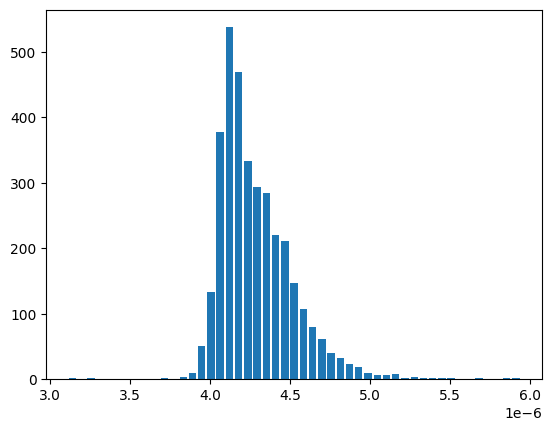

In [11]:
# show the histogram of IG scores
scores = patch_preds[0, :].detach().numpy()
bins = np.linspace(scores.min(), scores.max(), 50)
plt.hist(scores, bins, histtype='bar', rwidth=0.8)
plt.show()

In [12]:
# Heatmap with Captum
heatmap = draw_heatmap(
  scores=patch_preds[0, :],
  coords=coords,
  wsi=wsi,
  cmap='jet',
  alpha=1.0,
  use_holes=True,
  vis_level=1,
  blank_canvas=False,
  convert_to_percentiles=False
)

heatmap.save(os.path.join('data', 'interpretability', 'ig_heatmap.png'))



creating heatmap for: 
w: 33333, h: 15653
scaled patch size:  [256 256]

computing heatmap image
total of 3479 patches
progress: 694/3479
progress: 1389/3479
progress: 2084/3479
progress: 2779/3479
progress: 3474/3479
Done


In [13]:
# Extract the most important patches 
n_samples = 10 

# sort attention weights 
to_keep = np.argsort(patch_preds[0, :])[-n_samples:]
scores_to_keep = attention[to_keep]
coords_to_keep = coords[to_keep]

print('Indices to keep:', to_keep)
print('Scores:', scores_to_keep)

for idx in range(n_samples):
    patch = wsi.read_region(coords_to_keep[idx], 1, (256, 256))
    patch.show()

Indices to keep: tensor([2094,  360,  598,  581,  295, 1082, 2355,  483, 2696,  656])
Scores: [-3.3326893 -3.029744  -2.7310638 -3.22642   -3.2188368 -2.9249716
 -2.6320882 -2.5108652 -2.5027585 -2.6388512]


The following link at [http://clam.mahmoodlab.org](http://clam.mahmoodlab.org) visualizes high-attention heatmaps for LUAD vs LUSC subtyping via CLAM (similar to `ABMIL`) and confidence scores for each slides.

#### Discussion

- What is the main advantage of IG over attention for model interpretability?


- What are the limitations of feature-attribution methods?


- What's the difference interpretability and explaianability? Link it to the notion of control.


- If you were a clinical pathologist looking at these visualizations, what insights or concerns would you have in letting an AI algorithm assist you medical diagnoses?